<a href="https://colab.research.google.com/github/iambaangkok/261459-Deep-Learning/blob/master/Identification_of_Surface_Cracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle

In [1]:
! pip install -q kaggle

In [2]:
%reset -f

from google.colab import files

In [3]:
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iambaangkok","key":"4dc0b759a44f63015879dfef976d16d1"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# ! kaggle datasets list

In [8]:
! kaggle datasets download -d arunrk7/surface-crack-detection

 95% 222M/233M [00:01<00:00, 139MB/s]
100% 233M/233M [00:01<00:00, 139MB/s]


In [9]:
! mkdir dataset

In [ ]:
! unzip surface-crack-detection.zip -d dataset

# Split data into train - test

In [11]:
import os
import numpy as np
import shutil

In [12]:
# # Creating Train / Val / Test folders (One time use)
root_dir = 'dataset'
posCls = '/Positive'
negCls = '/Negative'

os.makedirs(root_dir +'/train' + posCls)
os.makedirs(root_dir +'/train' + negCls)
os.makedirs(root_dir +'/val' + posCls)
os.makedirs(root_dir +'/val' + negCls)
os.makedirs(root_dir +'/test' + posCls)
os.makedirs(root_dir +'/test' + negCls)

In [13]:
# Creating partitions of the data after shuffeling
def loadDataset(currentCls):
  src = "dataset"+currentCls # Folder to copy images from

  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                            [int(len(allFileNames)*(1 - (val_ratio + test_ratio))), 
                                                            int(len(allFileNames)*(1 - val_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
  test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

  print('Total images: ', len(allFileNames))
  print('Training: ', len(train_FileNames))
  print('Validation: ', len(val_FileNames))
  print('Testing: ', len(test_FileNames))

  # Copy-pasting images
  for name in train_FileNames:
      shutil.copy(name, "dataset/train"+currentCls)

  for name in val_FileNames:
      shutil.copy(name, "dataset/val"+currentCls)

  for name in test_FileNames:
      shutil.copy(name, "dataset/test"+currentCls)

In [14]:
loadDataset(posCls)

Total images:  20000
Training:  14000
Validation:  3000
Testing:  3000


In [15]:
loadDataset(negCls)

Total images:  20000
Training:  14000
Validation:  3000
Testing:  3000


# Load data into DataLoader

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torchvision

from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

In [43]:
batch_size = 128

transform = torchvision.transforms.Compose([ 
                  torchvision.transforms.ToTensor(),
                  #torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

ds_train = "dataset/train"
ds_val = "dataset/val"
ds_test  = "dataset/test"

ds_train = ImageFolder(root=ds_train, transform=transform)
ds_val = ImageFolder(root=ds_val, transform=transform)
ds_test = ImageFolder(root=ds_test, transform=transform)
                                    
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val   = DataLoader(ds_val, batch_size=batch_size)
dl_test  = DataLoader(ds_test, batch_size=batch_size)

## Sample images

In [44]:
labels_map = {
    0: "Negative",
    1: "Positive",
}

rgb_map = {
    0: "R",
    1: "G",
    2: "B",
}

Define sampleImage()

> result is best when imgCount is divisible by 3

In [130]:
def sampleImage(imgCount = 1, splitChannel = False, width = 15, height = 15):
  if splitChannel:
    fig, ax = plt.subplots(imgCount,3,figsize=(height,width))
    for j in range(0,imgCount):
      sample_idx = torch.randint(len(ds_train), size=(1,)).item()
      img, label = ds_train[sample_idx]
      imgs = []
      for i in range(0,3):
        imgs.append(img.permute([1,2,0])[:,:,i])
        if imgCount == 1:
          ax[i].imshow(imgs[i], cmap='viridis'), ax[i].set_title(f"{sample_idx} {labels_map[label]} {rgb_map[i%3]} \nmax= {str(imgs[0].max().item())} \nmin= + {str(imgs[0].min().item())}", fontsize=16)
        else:
          ax[j][i].imshow(imgs[i], cmap='viridis'), ax[j][i].set_title(f"{sample_idx} {labels_map[label]} {rgb_map[i%3]} \nmax= {str(imgs[0].max().item())} \nmin= + {str(imgs[0].min().item())}", fontsize=16)
  else:
    nRows = int((imgCount-1)/3+1)
    fig, ax = plt.subplots(nRows,3,figsize=(height,width))
    for i in range(0,nRows*3):
        sample_idx = torch.randint(len(ds_train), size=(1,)).item()
        img, label = ds_train[sample_idx]
        img = img.permute([1,2,0])
        if imgCount <= 3:
          if i >= imgCount:
            ax[i].axis("off")
          else:
            ax[i].imshow(img, cmap='viridis'), ax[i].set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)
        else:
          if i >= imgCount:
            ax[int(i/3)][i%3].axis("off")
          else:
            ax[int(i/3)][i%3].imshow(img, cmap='viridis'), ax[int(i/3)][i%3].set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)
          

    # fig, ax = plt.subplots(1,1,figsize=(height,width))
    # ax.imshow(img.permute([1,2,0]))
    # ax.set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)

Sample images: RGB

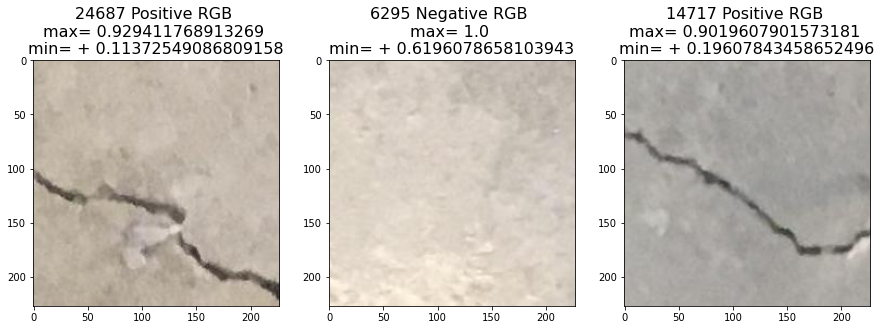

In [131]:
sampleImage(3)

Sample images: split channel

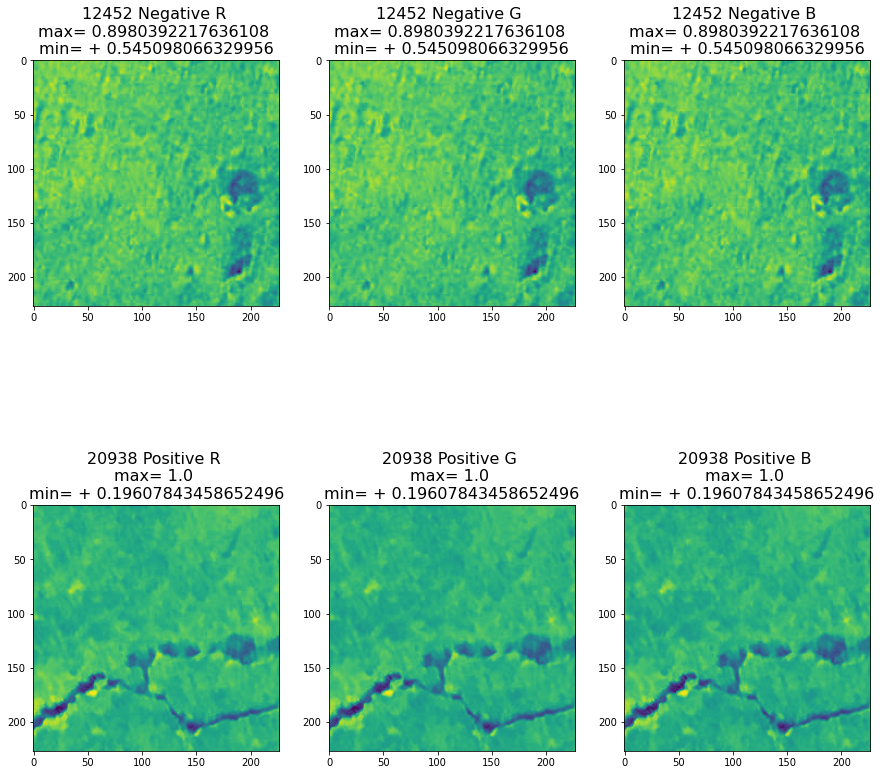

In [132]:
sampleImage(2, splitChannel=True)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(93312, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Sigmoid()
)

model(torch.zeros(128,3,227,227)).size()

torch.Size([128, 2])

In [ ]:
# nn.CrossEntropyLoss = nn.LogSoftmax + `nn.NLLLoss
loss_fn = nn.CrossEntropyLoss()  # 
optimizer = optim.Adam( model.parameters(), lr=0.005 )

In [ ]:
num_epoch = 10
model = model.to('cuda:0')

for epoch in range(num_epoch):
    trn_loss, val_loss = 0.0, 0.0    
    correct, val_correct = 0, 0

    model.train()    
    for i,(x, y) in enumerate(dl_train):
        x, y = x.to('cuda:0'), y.to('cuda:0')
        #y_onehot = nn.functional.one_hot(y, num_classes=10).float()   

        # nn.CrossEntropyLoss()( y_pred, y )
        # Note that: y can be either one-hot or class index
        
        optimizer.zero_grad()
        y_predict = model(x)        
        loss = loss_fn(y_predict, y)  # nn.CrossEntropyLoss      
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()

        pred = y_predict.argmax(dim=1, keepdim=True)          
        correct += pred.eq(y.view_as(pred)).sum().item()
        print(f'Batch {i}')            
        
    print(f'Epoch {epoch}: Train loss: {trn_loss/len(dl_train):8.5f}, Train acc: {100*correct/len(dl_train.dataset):6.2f}%')            

    model.eval()
    val_correct = 0
    with torch.no_grad():
      for x, y in dl_val:
          x, y = x.to('cuda:0'), y.to('cuda:0')
          #y_onehot = nn.functional.one_hot(y, num_classes=10).float()  

          y_predict = model(x)                    
          loss = loss_fn(y_predict, y)

          val_loss += loss.item()

          pred = y_predict.argmax(dim=1, keepdim=True)  
          val_correct += pred.eq(y.view_as(pred)).sum().item()
          
      print(f'\t Valid loss: {val_loss/len(dl_val):8.5f}, Valid acc: {100*val_correct/len(dl_val.dataset):6.2f}%')            

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
